In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from pyLDAvis import prepare
import string
import re
import nltk
import MeCab
nltk.download('wordnet')
import matplotlib.pyplot as plt  # max_iterの適切な値を見極めるために必要

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/takahashihiroki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# ファイルからデータを読み込む
with open('text.txt', 'r', encoding='utf-8') as f:#テキストファイルの名前を入れる
    lines = f.readlines()

In [3]:
# テキスト前処理を行う
exclude = set(string.punctuation)
m = MeCab.Tagger("-Owakati")  # MeCabを使って日本語テキストを分かち書き

In [4]:
# 特定の文章を取り除く条件を設定
#keywords_to_remove = [" ", " "]

In [5]:
# 特定の文章を取り除く
#lines = [line for line in lines if all(keyword not in line for keyword in keywords_to_remove)]

In [6]:
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    no_digits = re.sub(r'\d+', '', punc_free)  # 数字を削除する
    no_alpha = re.sub(r'[a-zA-Z]+', '', no_digits)  # 英字を削除する
    normalized = m.parse(no_alpha).strip()
    return normalized
lines = [clean(line) for line in lines]

In [7]:
# 文書-単語行列の作成
vect = CountVectorizer(max_df=1.0, stop_words=None)#1.0なら全て
data = vect.fit_transform(lines)

In [8]:
# 最適なパラメータでLDAの適用と学習
lda = LatentDirichletAllocation(n_components=8,#トピックの数
                                max_iter=40,
                                learning_method='online',
                                learning_offset=10,#デフォルト
                                random_state=0)

lda.fit(data)

LatentDirichletAllocation(learning_method='online', learning_offset=10,
                          max_iter=40, n_components=8, random_state=0)

In [9]:
# pyLDAvisを用いた可視化
pyLDAvis.enable_notebook()

In [10]:
# 必要なデータを取得
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]  # 各トピックの単語分布
doc_topic_dists = lda.transform(data)  # 各文書のトピック分布
term_frequency = data.sum(axis=0).A1  # 各単語の出現回数
vocab = vect.get_feature_names_out()  # 単語リスト
doc_lengths = data.sum(axis=1).A1  # 各文書の単語数

In [11]:
# pyLDAvis.prepare 関数でデータを可視化形式に変換
panel = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency,
    mds='tsne'
)

/Users/takahashihiroki/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [12]:
# 結果を表示
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      69.364136 -17.668550       1        1  67.825101
0      67.717026  29.575682       2        1  23.201384
1     -35.270512   2.779470       3        1   3.595000
7      19.267048   4.472447       4        1   1.240587
3     -13.413957 -39.149437       5        1   1.161750
2      29.734779  57.823673       6        1   1.006082
6      33.006161 -48.005516       7        1   0.991164
5     -16.005821  45.947685       8        1   0.978931, topic_info=      Term         Freq        Total Category  logprob  loglift
742     から  1988.000000  1988.000000  Default  30.0000  30.0000
155     ある  1595.000000  1595.000000  Default  29.0000  29.0000
2384    ない  2323.000000  2323.000000  Default  28.0000  28.0000
334     いる  1187.000000  1187.000000  Default  27.0000  27.0000
1166    ここ   102.000000   102.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
10706   脚本     1.180778     2.742687   Topic8  -6.6663   3.7837
5949    向上     1.183811     2.784761   Topic8  -6.6637   3.7710
9900    白い     1.726380    12.099224   Topic8  -6.2864   2.6793
4326    三毛     1.323538    13.579677   Topic8  -6.5522   2.2982
6403   大和魂     1.183635     6.354912   Topic8  -6.6639   2.9458

[427 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
51         2  0.946478    あし
77         1  0.692669    あっ
77         2  0.305321    あっ
102        1  0.997852   あなた
104        1  0.995258    あの
...      ...       ...   ...
12593      1  0.250076  飲み干し
12593      4  0.750229  飲み干し
12610      5  0.530481    養子
12686      3  0.823762    高等
12707      2  0.966913    鳴く

[553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 8, 4, 3, 7, 6])

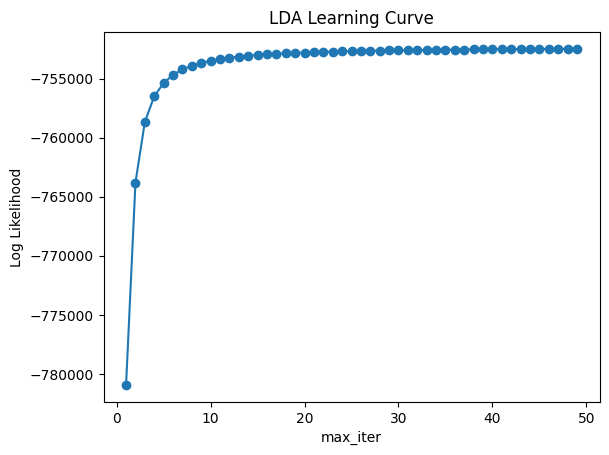

In [13]:
# ここからは任意

#最適なlearning_offsetの値をグラフから探る
likelihoods = []
max_iters_range = range(1, 50)#適切な値を探る

for max_iter in max_iters_range:
    lda = LatentDirichletAllocation(n_components=8, max_iter=max_iter,
                                    learning_method='online',
                                    learning_offset=10,
                                    random_state=0)
    lda.fit(data)
    likelihood = lda.score(data)
    likelihoods.append(likelihood)

# 学習曲線をプロット
plt.plot(max_iters_range, likelihoods, marker='o')
plt.xlabel('max_iter')
plt.ylabel('Log Likelihood')
plt.title('LDA Learning Curve')
plt.show()